In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import json

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import OneHotEncoder, BinaryEncoder
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

n_splits = 10
seed = 42
np.random.seed(seed)

In [2]:
k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

#### 1 Read and describe data

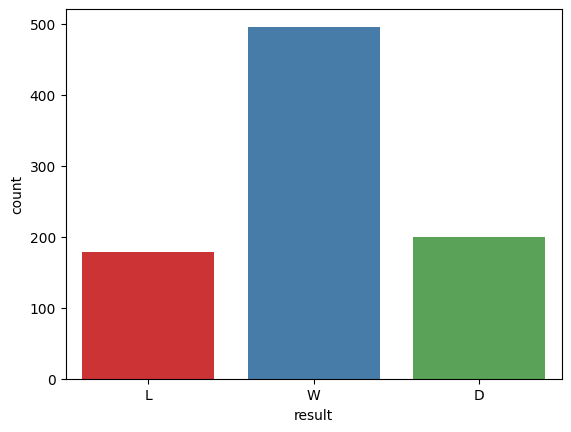

In [3]:
matches_df = pd.read_csv('arsenal.csv')
matches_df = matches_df.drop(columns=["opponent", "formation_team1", "formation_team2"])

sns.countplot(x='result', data=matches_df, palette="Set1") 
matches_df.loc[matches_df["result"] == "W", "result"] = 0
matches_df.loc[matches_df["result"] == "L", "result"] = 1
matches_df.loc[matches_df["result"] == "D", "result"] = 2

### Chia dữ liệu

In [4]:
X = matches_df.drop("result", axis=1)
y = matches_df["result"].astype("int")

In [5]:
X.head()

,venue,season,win_percent_before_team1,lose_percent_before_team1,draw_percent_before_team1,win_percent_before_team2,lose_percent_before_team2,draw_percent_before_team2,total_goals_before_team1,total_lost_goals_before_team1,total_goals_before_team2,total_lost_goals_before_team2,goals_achieved,goals_lost,date_time,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6
0,Away,2000-2001,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0,0,0,0,0,1,2000-08-19 00:00:00,0.0,0.0,0.0,0
1,Home,2000-2001,0.000000,1.000000,0.00,1.000000,0.000000,0.000000,0,1,1,0,2,0,2000-08-21 00:00:00,0.0,0.0,0.0,1
2,Home,2000-2001,0.500000,0.500000,0.00,0.500000,0.500000,0.000000,2,1,4,3,5,3,2000-08-26 00:00:00,0.0,0.0,0.0,0
3,Away,2000-2001,0.666667,0.333333,0.00,0.333333,0.333333,0.333333,7,4,5,5,2,2,2000-09-06 00:00:00,0.0,0.0,0.0,1
4,Away,2000-2001,0.500000,0.250000,0.25,0.250000,0.500000,0.250000,9,6,2,7,1,1,2000-09-09 00:00:00,0.0,0.0,0.0,0


In [6]:
# Xác định các cột phân loại và cột số
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [7]:
numerical_cols, categorical_cols

(Index(['win_percent_before_team1', 'lose_percent_before_team1',
        'draw_percent_before_team1', 'win_percent_before_team2',
        'lose_percent_before_team2', 'draw_percent_before_team2',
        'total_goals_before_team1', 'total_lost_goals_before_team1',
        'total_goals_before_team2', 'total_lost_goals_before_team2',
        'goals_achieved', 'goals_lost', 'head2head_win_percent',
        'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6'],
       dtype='object'),
 Index(['venue', 'season', 'date_time'], dtype='object'))

In [8]:
X.drop(columns=["date_time"], inplace=True)

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ("venue", OneHotEncoder(use_cat_names=True), ["venue"]),
        ("season", BinaryEncoder(), ["season"]),
        ('num', StandardScaler(), numerical_cols),
    ]
)

In [10]:
transformed_X = preprocessor.fit_transform(X)

# Hiển thị dữ liệu sau khi tiền xử lý
columns = (
    list(preprocessor.named_transformers_["venue"].get_feature_names_out())
    + list(preprocessor.named_transformers_["season"].get_feature_names_out())
    + numerical_cols.tolist()
)

transformed_X = pd.DataFrame(transformed_X, columns=columns)

In [11]:
transformed_X

,venue_Away,venue_Home,season_0,season_1,season_2,season_3,season_4,win_percent_before_team1,lose_percent_before_team1,draw_percent_before_team1,...,total_goals_before_team1,total_lost_goals_before_team1,total_goals_before_team2,total_lost_goals_before_team2,goals_achieved,goals_lost,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-2.163616,-0.980361,-1.068916,...,-2.382405,-1.859724,-1.847212,-2.017696,-1.393853,0.044962,-1.948832,-1.169633,-0.973674,-0.595390
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-2.163616,3.828923,-1.068916,...,-2.382405,-1.462638,-1.536144,-2.017696,0.013673,-0.990338,-1.948832,-1.169633,-0.973674,1.679572
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.186972,1.424281,-1.068916,...,-1.838193,-1.462638,-0.602939,-1.049777,2.124962,2.115560,-1.948832,-1.169633,-0.973674,-0.595390
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.471910,0.622734,-1.068916,...,-0.477663,-0.271380,-0.291871,-0.404498,0.013673,1.080261,-1.948832,-1.169633,-0.973674,1.679572
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.186972,0.221960,0.131728,...,0.066549,0.522792,-1.225076,0.240781,-0.690090,0.044962,-1.948832,-1.169633,-0.973674,-0.595390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,0.0,1.0,1.0,0.0,1.0,1.0,1.0,-1.372958,-0.018504,1.812629,...,0.882868,2.905308,-1.536144,0.240781,0.717436,0.044962,-0.477415,0.410062,0.503041,1.679572
871,1.0,0.0,1.0,0.0,1.0,1.0,1.0,-1.372958,-0.018504,1.812629,...,0.610762,2.905308,2.818812,0.240781,0.013673,-0.990338,0.626148,-0.643068,0.010802,-0.595390
872,0.0,1.0,1.0,0.0,1.0,1.0,1.0,-0.582301,-0.018504,0.852114,...,0.610762,2.111136,1.574539,0.886061,-1.393853,2.115560,-0.845269,0.410062,0.995279,-0.595390
873,1.0,0.0,1.0,0.0,1.0,1.0,1.0,-0.582301,0.943353,-0.108401,...,0.066549,2.508222,1.885607,1.531340,-1.393853,0.044962,1.729711,-1.169633,-0.973674,-0.595390


### Thử nghiệm các mô hình

In [12]:
algorithms = [
    ("LR", LogisticRegression(random_state=seed, class_weight='balanced')),
    (
        "SVC",
        SVC(
            probability=True,
            random_state=seed,
            class_weight='balanced',
        ),
    ),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed, class_weight='balanced')),
    ("SGDC", CalibratedClassifierCV(SGDClassifier(random_state=seed, class_weight='balanced'))),
    ("NB", GaussianNB()),
    (
        "RF",
        RandomForestClassifier(
            n_estimators=100,
            random_state=seed,
            class_weight='balanced'
        ),
    ),
]

cv_results = {}
for name, model in algorithms:
    # Thực hiện cross-validation
    cv_scores = cross_val_score(
        model, transformed_X, y, cv=k_fold, scoring="accuracy"
    )
    cv_results[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    print(f"Accuracy {name}: {score}")

Accuracy LR: 0.7040752351097178
Accuracy SVC: 0.7931687565308254
Accuracy KNN: 0.6571055381400209
Accuracy DTC: 0.9052115987460816
Accuracy SGDC: 0.6148249738766981
Accuracy NB: 0.6388192267502613
Accuracy RF: 0.8241379310344827


In [80]:
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, average='weighted')

algorithms = [
    ("LR", LogisticRegression(random_state=seed, class_weight='balanced')),
    (
        "SVC",
        SVC(
            probability=True,
            random_state=seed,
            class_weight='balanced',
        ),
    ),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed, class_weight='balanced')),
    ("SGDC", CalibratedClassifierCV(SGDClassifier(random_state=seed, class_weight='balanced'))),
    ("NB", GaussianNB()),
    (
        "RF",
        RandomForestClassifier(
            n_estimators=100,
            random_state=seed,
            class_weight='balanced'
        ),
    ),
]

cv_results = {}
for name, model in algorithms:
    # Tạo pipeline bao gồm preprocessor và mô hình
    pipeline = Pipeline([("preprocessor", preprocessor), ("model", model)])
    
    # Thực hiện cross-validation
    cv_scores = cross_val_score(
        pipeline, X, y, cv=k_fold, scoring=scorer
    )
    cv_results[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    print(f"F1 score {name}: {score}")

F1 score LR: 0.7145543780042682
F1 score SVC: 0.7992609281349263
F1 score KNN: 0.6276844185909644
F1 score DTC: 0.9044502062064662
F1 score SGDC: 0.5431968519635348
F1 score NB: 0.635588313571027
F1 score RF: 0.8192745296491892


### Thử nghiệm lại preprocessor

In [21]:
transformed_X = preprocessor.fit_transform(X)
new_columns = numerical_cols.to_list() + list(
    preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_cols)
)

transformed_X = pd.DataFrame(transformed_X, columns=new_columns)
transformed_X

,win_before_team1,win_before_team2,draw_before_team2,lose_before_team1,lose_before_team2,history_team1_win_team2,history_team1_draw_team2,history_team1_lose_team2,is_opponent_big6,venue_Away,venue_Home
0,-2.163616,-1.362390,-1.200677,-0.980361,-1.435440,-2.254012,-1.279594,-1.045951,-0.595390,1.0,0.0
1,-2.163616,2.376723,-1.200677,3.828923,-1.435440,-2.254012,-1.279594,-1.045951,1.679572,0.0,1.0
2,-0.186972,0.507166,-1.200677,1.424281,0.540040,-2.254012,-1.279594,-1.045951,-0.595390,0.0,1.0
3,0.471910,-0.116019,0.426005,0.622734,-0.118454,-2.254012,-1.279594,-1.045951,1.679572,1.0,0.0
4,-0.186972,-0.427612,0.019334,0.221960,0.540040,-2.254012,-1.279594,-1.045951,-0.595390,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
870,-1.372958,-1.362390,-0.224668,-0.018504,1.725328,-0.983496,0.436062,1.338160,1.679572,0.0,1.0
871,-1.372958,1.628900,-1.200677,-0.018504,-0.645248,0.435321,-0.069070,-0.276331,-0.595390,1.0,0.0
872,-0.582301,0.881078,-1.200677,-0.018504,0.144944,-0.768993,0.224390,1.248916,-0.595390,0.0,1.0
873,-0.582301,0.133255,-0.224668,0.943353,0.144944,1.829791,-1.279594,-1.045951,-0.595390,1.0,0.0


In [22]:
X = transformed_X

# Chọn bộ siêu tham số

### SVC

In [16]:
best_params_SVC = {}
models_tuned_SVC = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("SVC", SVC(probability=True)),
]

# Define parameter grid with correct keys
param_grid = {
    "SVC": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],  # Expanded C range
        "gamma": [0.001, 0.01, 0.1, 1, 10, 100],  # More granular gamma range
        "kernel": ["linear", "poly", "rbf", "sigmoid"],  # Added kernel options
        "class_weight": ["balanced"]
    }
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_SVC[name] = randomized_search.best_params_
        models_tuned_SVC[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


Model processing:  SVC
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [17]:
with open('best_params/best_params_SVC.json', 'w') as f:
    json.dump(best_params_SVC, f)

### RF

In [ ]:
best_params_RF = {}
models_tuned_RF = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ('RF', RandomForestClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "RF": {
        "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],  # More options for n_estimators
        "max_features": ["auto", "sqrt", "log2", 0.2, 0.4, 0.6],  # More granular control
        "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)] + [None],  # Added max_depth
        "min_samples_split": [2, 5, 10, 20],  # Added min_samples_split
        "min_samples_leaf": [1, 2, 4, 6],  # Added min_samples_leaf
        "class_weight": ["balanced"]
    }
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_RF[name] = randomized_search.best_params_
        models_tuned_RF[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


### Các thuật toán khác

In [52]:
best_params_random_other = {}
models_tuned_random_other = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("LR", LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "LR": {
        "C": np.logspace(-4, 4, 20),  # More granular range for C
        "solver": ["liblinear", "lbfgs", "saga", "newton-cg"],  # Added 'newton-cg'
        "penalty": ["l1", "l2", "elasticnet", "none"],  # Different norms for regularization
        "class_weight": ["balanced", None]  # Added class_weight
    },
    "DTC": {
        "max_depth": [None, 3, 5, 10, 15, 20, 30, 50, 100],  # Expanded range
        "min_samples_split": [2, 5, 10, 20, 40, 100],  # More options
        "min_samples_leaf": [1, 2, 5, 10, 20],  # Added min_samples_leaf
        "class_weight": ["balanced"]
    },
    "KNN": {
        "n_neighbors": list(range(1, 21)),  # More neighbors
        "weights": ["uniform", "distance"],  # Existing weights
        "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]  # Added distance metrics
    },
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_random_other[name] = randomized_search.best_params_
        models_tuned_random_other[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


Model processing:  LR
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model processing:  KNN
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model processing:  DTC
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [53]:
with open('best_params/best_params_random_other_balanced.json', 'w') as f:
    json.dump(best_params_random_other, f)

#### Thử nghiệm bộ tham số

In [46]:
algorithms_score_df = []

##### SVC

##### Trước resampling

In [47]:
with open('best_params/best_params_SVC.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("SVC", SVC(probability=True, **best_params.get("SVC", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name + "before_resampling",
        "score": score
    })
    print(f"{name}: {score}")

SVC: 0.574857142857143


##### Sau resampling

In [48]:
with open('best_params/best_params_SVC.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("SVC", SVC(probability=True, **best_params.get("SVC", {}), class_weight="balanced", random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name  + "after_resampling",
        "score": score
    })
    print(f"{name}: {score}")

SVC: 0.47314285714285714


##### Random forest

##### Trước resampling

In [49]:
with open('best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ('RF', RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name + "before_resampling",
        "score": score
    })
    print(f"{name}: {score}")

RF: 0.6022857142857143


##### Sau resampling

In [50]:
with open('best_params/best_params_RF_balanced.json', 'r') as f:
    best_params_RF = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ('RF', RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name + "after_resampling",
        "score": score
    })
    print(f"{name}: {score}")

RF: 0.5577142857142857


##### Các thuật toán khác

##### Trước resampling

In [54]:
with open('best_params/best_params_random_other.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("LR", LogisticRegression(**best_params.get("LR", {}), random_state=42)),
    ('KNN', KNeighborsClassifier(**best_params.get("KNN", {}))),
    ("DTC", DecisionTreeClassifier(**best_params.get("DTC", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name + "before_resampling",
        "score": score
    })
    print(f"{name}: {score}")

LR: 0.6034285714285714
KNN: 0.5885714285714286
DTC: 0.598857142857143


##### Sau resampling

In [55]:
with open('best_params/best_params_random_other_balanced.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("LR", LogisticRegression(**best_params.get("LR", {}), random_state=42)),
    ('KNN', KNeighborsClassifier(**best_params.get("KNN", {}))),
    ("DTC", DecisionTreeClassifier(**best_params.get("DTC", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name + "after_resampling",
        "score": score
    })
    print(f"{name}: {score}")

LR: 0.6034285714285714
KNN: 0.5897142857142856
DTC: 0.4868571428571428


In [56]:
df = pd.DataFrame(algorithms_score_df)
df.sort_values(by="score", ascending=False)


,model,score
4,LRbefore_resampling,0.603429
7,LRafter_resampling,0.603429
2,RFbefore_resampling,0.602286
6,DTCbefore_resampling,0.598857
8,KNNafter_resampling,0.589714
5,KNNbefore_resampling,0.588571
0,SVCbefore_resampling,0.574857
3,RFafter_resampling,0.557714
9,DTCafter_resampling,0.486857
1,SVCafter_resampling,0.473143


#### Vẽ ma trận nhầm lẫn của model có độ chính xác cao nhất 

In [11]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Random forest

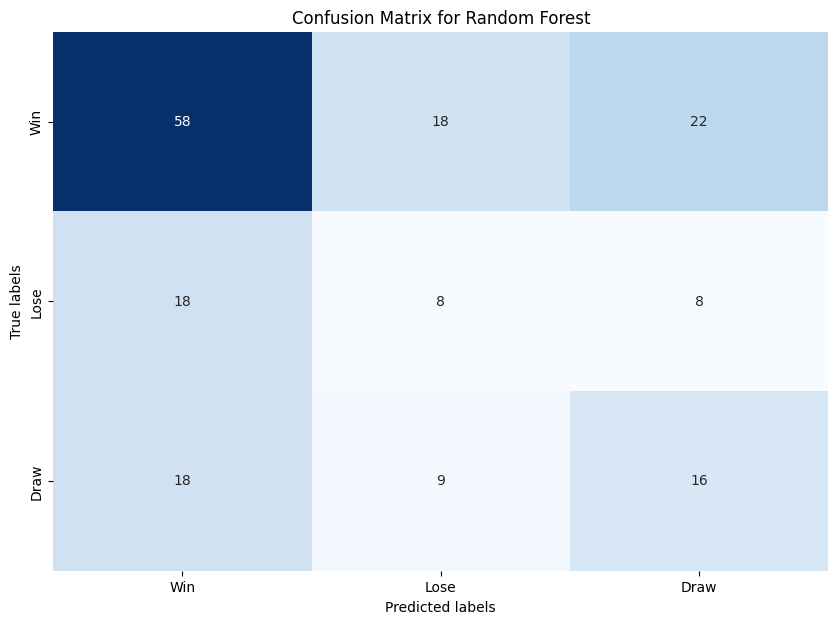

In [17]:
with open('best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)

rf_model = RandomForestClassifier(**best_params_RF.get("RF", {}), class_weight='balanced', random_state=42)

y_pred = rf_model.fit(X_train, y_train).predict(X_test)
# Tạo ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa nhãn cho các trục tương ứng với các lớp của 'Result'
labels = ['Win', 'Lose', 'Draw']

df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Vẽ ma trận confusion với nhãn cụ thể
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

##### Linear regression

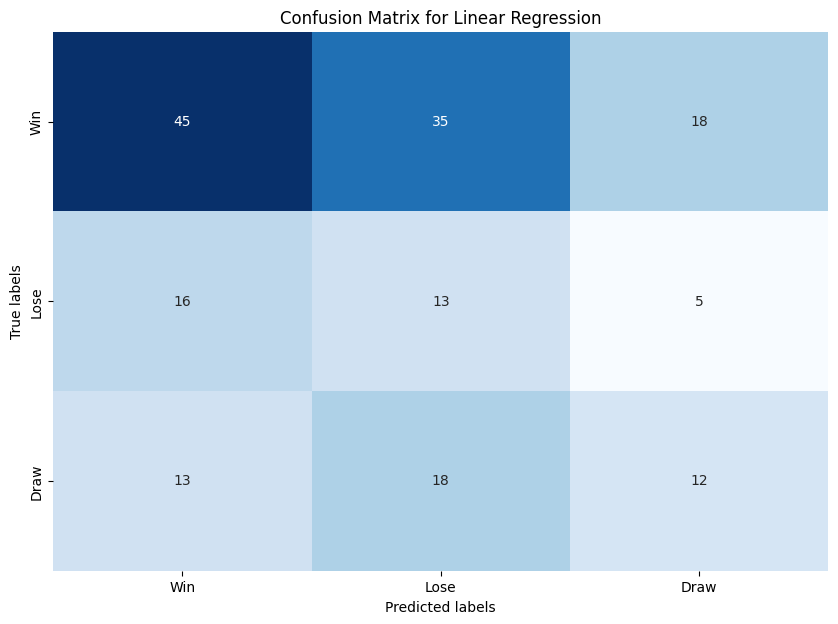

In [18]:
with open('best_params/best_params_random_other.json', 'r') as f:
    best_params_other = json.load(f)

lr_model = LogisticRegression(**best_params_other.get("LR", {}), class_weight='balanced', random_state=42)

y_pred = lr_model.fit(X_train, y_train).predict(X_test)
# Tạo ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa nhãn cho các trục tương ứng với các lớp của 'Result'
labels = ['Win', 'Lose', 'Draw']

df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Vẽ ma trận confusion với nhãn cụ thể
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Linear Regression')
plt.show()